In [45]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

In [46]:
# display
from IPython.core.display import display, HTML
display(HTML('''<style>
.container { 
    width:80% !important; 
    margin-left:0 !important;
}
div.prompt_container{
    width: 76px;
}
div.cell.code_cell.input_prompt{
    text-align: left !important;
}
.cm-s-ipython .CodeMirror-gutters{
    width: 27px !important;
}
</style>'''))

In [47]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

### Use Cuda

In [67]:
USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

True


## Replay Buffer

In [65]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        '''初始化: 队列'''
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        '''加入队列
        state: (4,)
        action: int
        reward: float
        next_state: (4,)
        done: bool'''
        state      = np.expand_dims(state, 0)  # 从一维变成1*n的二维数组
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        '''取样'''
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
        # concatenate将state降回一维
        
    def __len__(self):
        return len(self.buffer)

## Cart Pole Environment

In [50]:
env_id = "CartPole-v0"
env = gym.make(env_id)

In [51]:
env.observation_space.shape[0]

4

## Epsilon greedy exploration

In [52]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + \
    (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

\begin{align}
\epsilon_{start} &= 1.0\\
\epsilon_{final} &= 0.01\\
\epsilon_{decay} &= 500
\end{align}
$$\epsilon_{final} + (\epsilon_{start} - \epsilon_{final}) \times \exp(- \frac{{idx}}{\epsilon_{decay}})$$

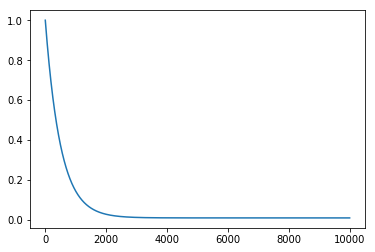

In [53]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])

## Deep Q Network

In [54]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__() # 官方继承步骤
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )
        
    def forward(self, x):
        '''前馈'''
        return self.layers(x)
    
    def act(self, state, epsilon):
        '''行动'''
        if random.random() > epsilon: # exploit
            with torch.no_grad():
                state   = Variable(torch.FloatTensor(state).unsqueeze(0)) #, volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else: # explore
            action = random.randrange(env.action_space.n)
        return action

In [55]:
model = DQN(env.observation_space.shape[0], env.action_space.n)
print(model) # 查看nn结构

DQN(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [56]:
if USE_CUDA:
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000) # 队列容量1000个

## <center>Computing Temporal Difference Loss 计算DP误差</center>

In [62]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    # UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
    with torch.no_grad():
        next_state = Variable(torch.FloatTensor(np.float32(next_state))) #, volatile=True)
    state      = Variable(torch.FloatTensor(np.float32(state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = model(state) # 向前 传递state参数
    next_q_values = model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
#     print(expected_q_value)
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
    
    # 官方步骤
    optimizer.zero_grad() # optimizer = optim.Adam(model.parameters())
    loss.backward()
    optimizer.step() # 官方: 对所有的参数进行更新
    
    return loss, expected_q_value

误差函数(eq2)
\begin{equation}
L_{i}\left(\theta_{i}\right)=\mathbb{E}_{s, a \sim \rho(\cdot)}\left[\left(y_{i}-Q\left(s, a ; \theta_{i}\right)\right)^{2}\right]
\end{equation}

In [63]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

## <center>Training</center>

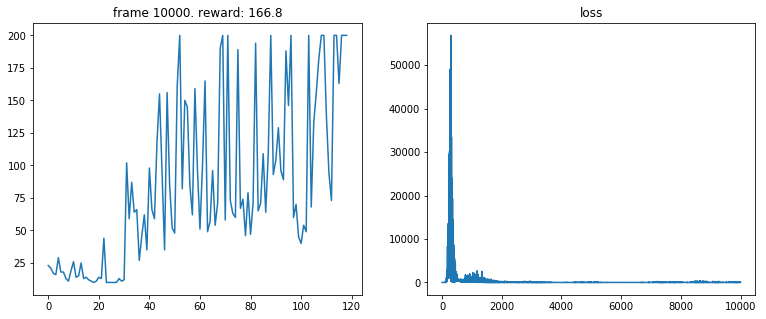

finish


In [64]:
num_frames = 10000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1): # 帧数
    epsilon = epsilon_by_frame(frame_idx) # 完成一整个迭代之后才改变epsilon
    action = model.act(state, epsilon) # -> (return action)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done) # 存进缓存器里
    
    state = next_state
    episode_reward += reward
    
    if done: # game over
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:  # 缓存器存了batch_size个以后才
        loss, study = compute_td_loss(batch_size) # return loss, expected_q_value
        losses.append(loss.data.item())
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)  # 上面定义的函数
print("finish")

`action = model.act(state, epsilon)`
```python
def act(self, state, epsilon):
    '''行动'''
    if random.random() > epsilon: # exploit
        with torch.no_grad():
            state   = Variable(torch.FloatTensor(state).unsqueeze(0))
        q_value = self.forward(state)
        action  = q_value.max(1)[1].item()
    else: # explore
        action = random.randrange(env.action_space.n)
    return action
  ```

In [18]:
Variable(study.data)

tensor([1.0339, 1.0000, 0.9921, 1.0463, 1.0361, 1.0131, 1.0561, 1.0951, 1.0478,
        1.0468, 1.0807, 1.0988, 1.0462, 1.0444, 1.0478, 1.0137, 1.0725, 1.0689,
        0.9985, 1.0296, 1.0315, 1.0563, 1.0001, 1.0154, 1.0500, 0.9982, 1.0470,
        1.0023, 1.0014, 1.0175, 1.0452, 1.0387], device='cuda:0')

<p><hr></p>

# <center>Atari Environment</center>

In [69]:
from common.wrappers import make_atari, wrap_deepmind, wrap_pytorch

In [70]:
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

In [ ]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0))  #, volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action

In [72]:
model = CnnDQN(env.observation_space.shape, env.action_space.n)

if USE_CUDA:
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=0.00001)

replay_initial = 10000
replay_buffer = ReplayBuffer(100000)

In [73]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

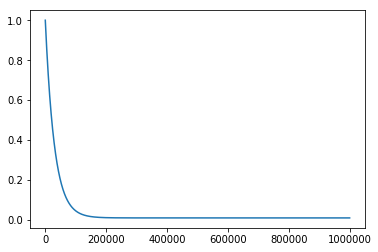

In [74]:
plt.plot([epsilon_by_frame(i) for i in range(1000000)])

In [80]:
num_frames = 1400000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        loss, study = compute_td_loss(batch_size)
        losses.append(loss.data.item())
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, losses)

D:\MUYI Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


KeyboardInterrupt: 